# **Blood Group Prediction from Finger Print Images**

# Machine Learning

In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.feature import hog
from tqdm import tqdm
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


## Data collection and Loading

In [3]:
#Mounting the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path to your dataset
train_dir = "/content/drive/MyDrive/BLOOD_GROUP_DATASET"

# Function to load and preprocess images
def load_images_and_labels(directory):
    images = []
    labels = []
    classes = os.listdir(directory)

    for label, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        for img_name in tqdm(os.listdir(class_path), desc=f'Loading {class_name}'):
            img_path = os.path.join(class_path, img_name)     # Load and preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels), classes

# Load data
images, labels, class_names = load_images_and_labels(train_dir)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")

Loading O+: 100%|██████████| 852/852 [00:20<00:00, 42.32it/s] 

Loaded 6001 images from 8 classes.


## Feature Extraction

In [5]:
# Extract HOG features

def extract_hog_features(images):
    features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
        features.append(hog_features)
    return np.array(features)

features = extract_hog_features(images)
print(f"Extracted features shape: {features.shape}")

Extracting HOG features: 100%|██████████| 6001/6001 [00:46<00:00, 128.82it/s]


Extracted features shape: (6001, 8100)


## Data Preprocessing

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training samples: 4800, Testing samples: 1201


## Random Forest Model

In [7]:
#Random Forest model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

## RF Evaluation

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8784346378018318
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       216
           1       0.99      0.90      0.94       135
           2       0.88      0.81      0.84       149
           3       0.87      0.92      0.90       121
           4       0.89      0.96      0.92       147
           5       0.88      0.87      0.87       123
           6       0.90      0.82      0.85       147
           7       0.86      0.90      0.88       163

    accuracy                           0.88      1201
   macro avg       0.89      0.88      0.88      1201
weighted avg       0.88      0.88      0.88      1201

Confusion Matrix:
 [[189   0   7   3   7   4   2   4]
 [  0 121   0   3   0   0   3   8]
 [ 14   0 120   1   7   5   1   1]
 [  5   0   0 111   0   4   0   1]
 [  2   0   2   0 141   2   0   0]
 [  8   0   2   2   4 107   0   0]
 [  7   1   5   4   0   0 120  10]
 [  6   0   0   3   0   0   8 14

In [9]:
from sklearn.preprocessing import label_binarize

# Your class names
class_names = ['A-', 'A+', 'B-', 'B+', 'AB-', 'AB+', 'O-', 'O+']

# Binarize the labels (for multi-class ROC)
y_test_bin = label_binarize(y_test, classes=class_names)
n_classes = y_test_bin.shape[1]

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Random Forest predicted probabilities
y_score_rf = rf_model.predict_proba(X_test_scaled)
print(y_score_rf)


[[0.14 0.   0.57 ... 0.03 0.13 0.07]
 [0.56 0.   0.12 ... 0.22 0.01 0.01]
 [0.49 0.01 0.17 ... 0.07 0.06 0.16]
 ...
 [0.06 0.   0.11 ... 0.02 0.14 0.61]
 [0.08 0.   0.83 ... 0.02 0.01 0.  ]
 [0.08 0.   0.16 ... 0.69 0.01 0.02]]


## Feature Importance for Random Forest

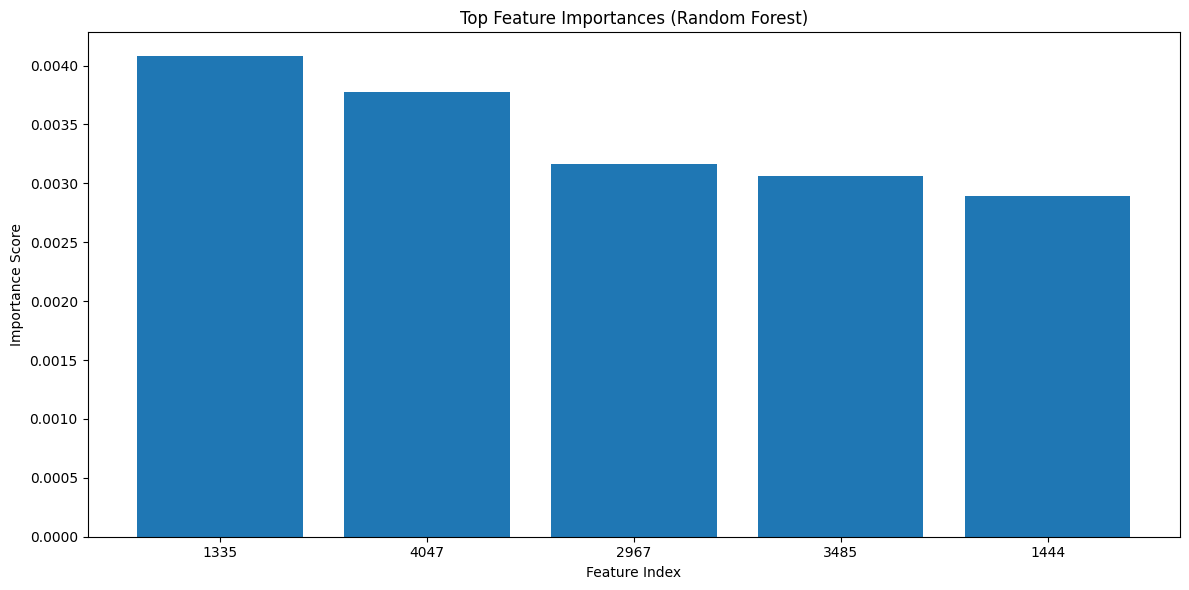

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Sort and plot top N features
N = 5  # Top 30 features
indices = np.argsort(importances)[::-1][:N]

plt.figure(figsize=(12, 6))
plt.title("Top Feature Importances (Random Forest)")
plt.bar(range(N), importances[indices], align="center")
plt.xticks(range(N), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=30, cv=3, verbose=2,
                                   random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
21 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

Best Parameters:
 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


## SVM Model

In [12]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True) #rbf is a model of nonlinear SVM
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

## SVM Evaluation

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          A-       0.90      0.92      0.91       216
          A+       0.95      0.90      0.92       135
          B-       0.94      0.89      0.91       149
          B+       0.93      0.93      0.93       121
         AB-       0.91      0.97      0.94       147
         AB+       0.94      0.94      0.94       123
          O-       0.87      0.90      0.89       147
          O+       0.90      0.90      0.90       163

    accuracy                           0.92      1201
   macro avg       0.92      0.92      0.92      1201
weighted avg       0.92      0.92      0.92      1201

Accuracy: 0.9159034138218152
Confusion Matrix:
 [[198   0   2   2   8   1   3   2]
 [  0 121   0   3   0   0   3   8]
 [  6   0 132   1   6   1   3   0]
 [  2   3   0 112   0   4   0   0]
 [  1   0   2   0 143   1   0   0]
 [  6   0   1   0   0 116   0   0]
 [  4   2   3   0   0   0 132   6]
 [  3   2   0   2   0   0  10 146

## Feature importance for SVM

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

#Compute permutation importance
result = permutation_importance(svm_model, X_test_scaled, y_test,
                                n_repeats=10, random_state=42, n_jobs=-1)

importances = result.importances_mean

#Plot top N important features
N = 5
indices = np.argsort(importances)[::-1][:N]

plt.figure(figsize=(12, 6))
plt.title("Top Feature Importances (SVM with RBF Kernel)")
plt.bar(range(N), importances[indices], align="center")
plt.xticks(range(N), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score (Mean Drop in Accuracy)")
plt.tight_layout()
plt.show()

In [ ]:
import shap

# Important: you might need to install SHAP first
# !pip install shap

# Since you're using an RBF SVM, use KernelExplainer (SHAP needs probability outputs)
background = shap.kmeans(X_train_scaled, 100)

explainer = shap.KernelExplainer(svm_model.predict_proba, background)

#explainer = shap.KernelExplainer(svm_model.predict_proba, X_train_scaled)

# Get SHAP values for a batch of samples (say, first 500 for speed)
shap_values = explainer.shap_values(X_test_scaled[:500])

# shap_values is a list: one array per class
# Let's plot global feature importance for one class, or averaged across classes

# Average the absolute SHAP values across samples and classes
mean_shap_values = np.mean(np.abs(np.array(shap_values)), axis=(0, 1))

# Now sort and plot
import matplotlib.pyplot as plt
import numpy as np

N = 5 # Top 30 features
indices = np.argsort(mean_shap_values)[::-1][:N]

plt.figure(figsize=(12, 6))
plt.title("Top Feature Importances (SHAP for SVM RBF)")
plt.bar(range(N), mean_shap_values[indices], align="center")
plt.xticks(range(N), indices)
plt.xlabel("Feature Index")
plt.ylabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()


## Experimentation (Ignore)




In [ ]:
'''import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to preprocess a single image: convert to grayscale, resize, normalize
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image at {image_path}")
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized.astype("float32") / 255.0
    return image_normalized

# Load images and corresponding labels from the dataset directory
def load_dataset(dataset_dir, target_size=(128, 128)):
    images = []
    labels = []
    blood_groups = os.listdir(dataset_dir)  # e.g., ['A+', 'A-', 'B+', ...]
    print(blood_groups)

    for group in blood_groups:
        image_files = glob(os.path.join(dataset_dir, group, "*.BMP"))
        for img_path in image_files:
            try:
                img = preprocess_image(img_path, target_size)
                images.append(img)
                labels.append(group)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    images = np.array(images)
    labels = np.array(labels)
    # Expand dims to add channel dimension for CNNs (grayscale -> 1 channel)
    images = np.expand_dims(images, -1)
    return images, labels

# Example usage:
dataset_dir = "/content/drive/MyDrive/BLOOD_GROUP_DATASET"  # Set this to your dataset directory
X, y = load_dataset(dataset_dir, target_size=(128, 128))
print(f"Loaded {len(X)} images with labels: {np.unique(y)}")

# For deep learning pipelines, data augmentation can be set up as follows:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # 15% for validation
)
'''

In [ ]:
'''from skimage.filters import gabor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.feature import graycomatrix, graycoprops

# Function to extract features using Gabor filters
def extract_gabor_features(image):
    # Apply Gabor filter with a set frequency and theta
    filt_real, _ = gabor(image, frequency=0.6, theta=0)
    # You may add more filters (different theta, frequency) and aggregate features
    features = filt_real.flatten()
    return features

# Prepare feature vectors for ML models

def extract_glcm_features(image,
                           distances=[1],
                           angles=[0],
                           levels=256,
                           props=['contrast', 'dissimilarity', 'homogeneity', 'energy']):
    """
    Extract Gray‑Level Co‑occurrence Matrix (GLCM) properties.
    - distances, angles: for co‑occurrence matrix calculation
    - props: list of properties to compute
    Returns an array of property values.
    """
    glcm = graycomatrix(image,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=True,
                        normed=True)
    feats = []
    for prop in props:
        feats.append(graycoprops(glcm, prop)[0, 0])
    return np.array(feats)

def extract_lbp_features(image, P=8, R=1):
    """Local Binary Pattern histogram"""
    """
    Extract Local Binary Pattern (LBP) histogram features.
    - image: 2D uint8 fingerprint image
    - P: number of circularly symmetric neighbour set points
    - R: radius
    Returns a normalized histogram of LBP codes.
    """
    lbp = local_binary_pattern(image, P, R, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist

def extract_enhanced_features(images):
    """
    Combine Gabor, LBP, and GLCM features for each image.
    - images: array of shape (n_samples, H, W, 1) with float values [0,1]
    Returns a 2D array (n_samples x total_features).
    """
    enhanced = []
    for img in images:
        # Convert back to uint8 grayscale for these filters
        gray = (img.squeeze() * 255).astype('uint8')
        # 1. Gabor features (pre‑existing extract_gabor_features)
        gabor_feat = extract_gabor_features(gray)
        # 2. LBP features
        lbp_feat   = extract_lbp_features(gray)
        # 3. GLCM features
        glcm_feat  = extract_glcm_features(gray)
        # Concatenate all feature sets
        combined   = np.concatenate([gabor_feat, lbp_feat, glcm_feat])
        enhanced.append(combined)
    return np.array(enhanced)


# Extract features for our dataset
X_features = extract_enhanced_features(X)
print(f"Feature vector shape: {X_features.shape}")

# Split data into training and testing sets (70%-30% split; adjust as desired)
X_train_feat, X_test_feat, y_train_ml, y_test_ml = train_test_split(
    X_features, y, test_size=0.3, random_state=42, stratify=y)

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': [1e-3, 1e-4],
    'kernel': ['rbf']
}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, n_jobs=-1)
svm_grid.fit(X_train_feat, y_train_ml)
print("Best SVM parameters:", svm_grid.best_params_)

y_pred_svm = svm_grid.predict(X_test_feat)
print("SVM Classification Report:")
print(classification_report(y_test_ml, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test_ml, y_pred_svm))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_feat, y_train_ml)

y_pred_rf = rf_model.predict(X_test_feat)
print("Random Forest Classification Report:")
print(classification_report(y_test_ml, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test_ml, y_pred_rf))
'''

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers and then to categorical
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(np.unique(y))
y_cat = to_categorical(y_encoded, num_classes=num_classes)

# Split data for the CNN model (using the preprocessed images X from Section I)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y_cat)

# Define a simple CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model(input_shape=X_train.shape[1:], num_classes=num_classes)
cnn_model.summary()

# Train the CNN (feel free to adjust batch_size and epochs)
history = cnn_model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {cnn_acc:.4f}")
'''

# Deep Learning

In [20]:
# General libraries
import os
import glob
import shutil
import warnings
import time
import itertools
import pathlib
import math

# Data handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Image handling and visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix

# Define Constants
BATCH_SIZE = 128
IMG_SIZE_MOBILENET = (224, 224)
IMG_SIZE_RESNET = (224, 224)
IMG_SIZE_SEQUENTIAL=(128, 128)
EPOCHS = 20
NUM_CLASSES = 8


## Data Collection and Loading

A-                  :   1009 or 16.81%
O+                  :   852 or 14.2%
AB-                 :   761 or 12.68%
B-                  :   741 or 12.35%
O-                  :   713 or 11.88%
AB+                 :   708 or 11.8%
B+                  :   652 or 10.86%
A+                  :   565 or 9.42%


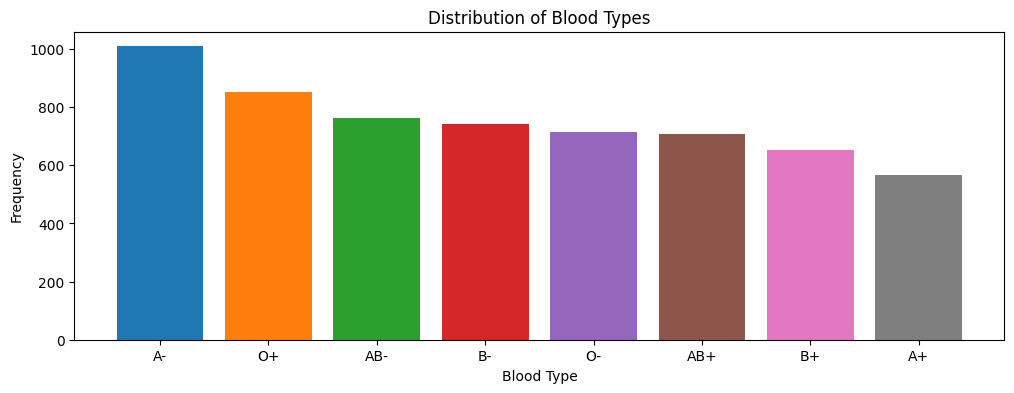

Total number of sample images to plot: 8


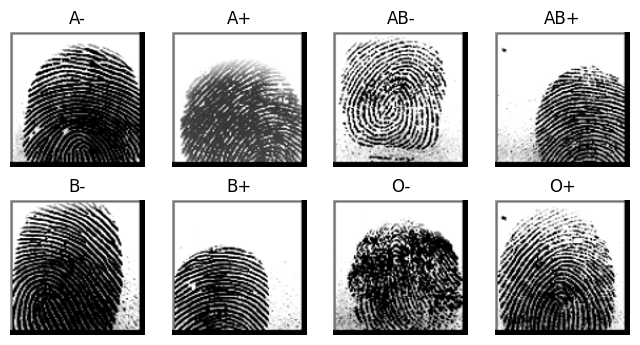

In [16]:
# Dataset directory path
file_path = "/content/drive/MyDrive/BLOOD_GROUP_DATASET"

# List all .BMP files recursively
filepaths = glob.glob(os.path.join(file_path, '**', '*.BMP'), recursive=True)
labels = os.listdir(file_path)

# Extract labels (folder names) for each file path
labels_path = [os.path.basename(os.path.dirname(path)) for path in filepaths]

# Create a DataFrame with file paths and labels
df = pd.DataFrame({'filePath': filepaths, 'label': labels_path})

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()

# Display class distribution
def get_class_distribution(df):
    labels_count = df['label'].value_counts()
    total_samples = len(df)
    for label, count in labels_count.items():
        percentage = round(count / total_samples * 100, 2)
        print(f"{label:<20s}:   {count} or {percentage}%")

get_class_distribution(df)
# Visualize distribution
def plot_class_distribution(df, label="label"):
    plt.figure(figsize=(12, 4))
    blood_type_counts = df[label].value_counts()
    colors = plt.cm.tab10(range(len(blood_type_counts)))
    plt.bar(blood_type_counts.index, blood_type_counts.values, color=colors)
    plt.xlabel('Blood Type')
    plt.ylabel('Frequency')
    plt.title('Distribution of Blood Types')
    plt.show()

plot_class_distribution(df)

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])

# Check encoded labels
df.head()

# Function to sample images and labels
def sample_images_data(data, labels, num_samples=1):
    sample_images = []
    sample_labels = []

    # Iterate through each label and sample a few images
    # Changed: Iterate directly through the labels list
    for label in labels:
        samples = data[data['label'] == label].head(num_samples)
        for j in range(len(samples)):
            img_path = samples.iloc[j]['filePath']
            img = Image.open(img_path).convert("RGB")  # Open the image and convert to RGB
            img = img.resize((128, 128))  # Resize image to target size
            img_array = np.array(img)  # Convert image to numpy array
            sample_images.append(img_array)
            sample_labels.append(samples.iloc[j]['label'])

    print(f"Total number of sample images to plot: {len(sample_images)}")
    return sample_images, sample_labels

# Plot sample images
def plot_images(images, labels, cmap="Blues"):
    f, ax = plt.subplots(2, 4, figsize=(8, 4))
    for i, img in enumerate(images):
        ax[i//4, i%4].imshow(img, cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title(labels[i])
    plt.show()

# Sample images from dataset and plot them
sample_images, sample_labels = sample_images_data(df, labels)
plot_images(sample_images, sample_labels)


## Data Preprocessing



Class distribution after oversampling:
category_encoded
1    1009
5    1009
4    1009
7    1009
2    1009
3    1009
0    1009
6    1009
Name: count, dtype: int64


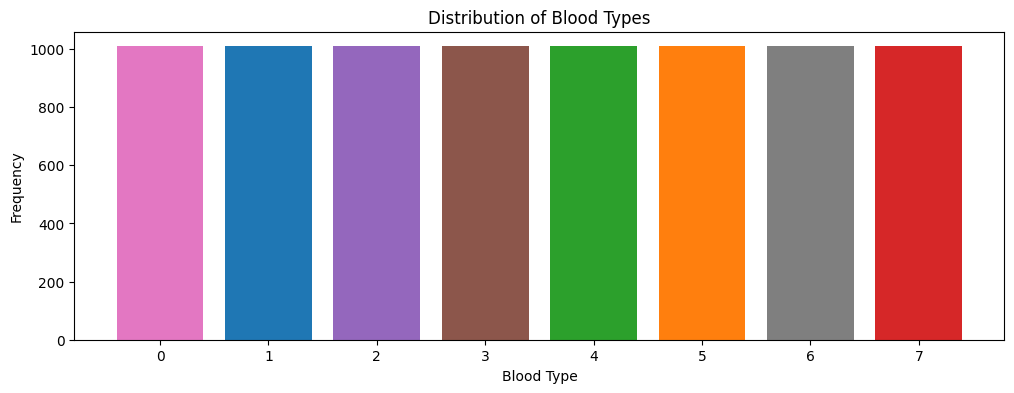

object
Found 6457 validated image filenames belonging to 8 classes.
Found 807 validated image filenames belonging to 8 classes.
Found 808 validated image filenames belonging to 8 classes.
Found 6457 validated image filenames belonging to 8 classes.
Found 807 validated image filenames belonging to 8 classes.
Found 808 validated image filenames belonging to 8 classes.
Found 6457 validated image filenames belonging to 8 classes.
Found 807 validated image filenames belonging to 8 classes.
Found 808 validated image filenames belonging to 8 classes.


In [17]:
# Apply oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['filePath']], df['category_encoded'])

# Create a new DataFrame with oversampled data
df_resampled = pd.DataFrame(X_resampled, columns=['filePath'])
df_resampled['category_encoded'] = y_resampled

# Check new class distribution
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())

# Visualize new class distribution
plot_class_distribution(df_resampled, "category_encoded")

# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(
    df_resampled,
    train_size=0.8,
    stratify=df_resampled['category_encoded'],
    random_state=42
    )

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['category_encoded'],
    random_state=42
    )

# Check the shape of the splits
train_df.shape, valid_df.shape, test_df.shape


#For Sequential
sequential_train_datagen = ImageDataGenerator(rescale=1./255)
sequential_valid_datagen = ImageDataGenerator(rescale=1./255)
sequential_test_datagen = ImageDataGenerator(rescale=1./255)

# Convert 'category_encoded' to string explicitly
train_df['category_encoded'] = train_df['category_encoded'].astype(str)
valid_df['category_encoded'] = valid_df['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)
# Check if the conversion was successful
print(train_df['category_encoded'].dtype)  # Should output: object (string type)


sequential_train_gen = sequential_train_datagen.flow_from_dataframe(
    train_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_SEQUENTIAL, batch_size=BATCH_SIZE, class_mode='categorical')

sequential_valid_gen = sequential_valid_datagen.flow_from_dataframe(
    valid_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_SEQUENTIAL, batch_size=BATCH_SIZE, class_mode='categorical')

sequential_test_gen = sequential_test_datagen.flow_from_dataframe(
    test_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_SEQUENTIAL, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

#For mobilenet
mobilenet_train_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)
mobilenet_valid_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)
mobilenet_test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)

mobilenet_train_gen = mobilenet_train_datagen.flow_from_dataframe(
    train_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_MOBILENET, batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb')

mobilenet_valid_gen = mobilenet_valid_datagen.flow_from_dataframe(
    valid_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_MOBILENET, batch_size=BATCH_SIZE, class_mode='categorical')

mobilenet_test_gen = mobilenet_test_datagen.flow_from_dataframe(
    test_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_MOBILENET, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


#For resenet
resnet_train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
resnet_valid_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
resnet_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

resnet_train_gen = resnet_train_datagen.flow_from_dataframe(
    train_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_RESNET, batch_size=BATCH_SIZE, class_mode='categorical')

resnet_valid_gen = resnet_valid_datagen.flow_from_dataframe(
    valid_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_RESNET, batch_size=BATCH_SIZE, class_mode='categorical')

resnet_test_gen = resnet_test_datagen.flow_from_dataframe(
    test_df, x_col='filePath', y_col='category_encoded',
    target_size=IMG_SIZE_RESNET, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

## Model Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Baseline CNN Model:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.1833 - loss: 2.4941 - val_accuracy: 0.7435 - val_loss: 1.0104
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6280 - loss: 1.0256 - val_accuracy: 0.8451 - val_loss: 0.4862
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7439 - loss: 0.6948 - val_accuracy: 0.8352 - val_loss: 0.4671
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7914 - loss: 0.5628 - val_accuracy: 0.8860 - val_loss: 0.3570
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8365 - loss: 0.4449 - val_accuracy: 0.8971 - val_loss: 0.2961
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8765 - loss: 0.3619 - val_accuracy: 0.9033 - val_loss: 0.2486
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8861 - loss: 0.3175 - val_accuracy: 0.9257 - val_loss: 0.2042
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9113 - loss: 0.2603 - val_accuracy: 0.9318 - val_lo

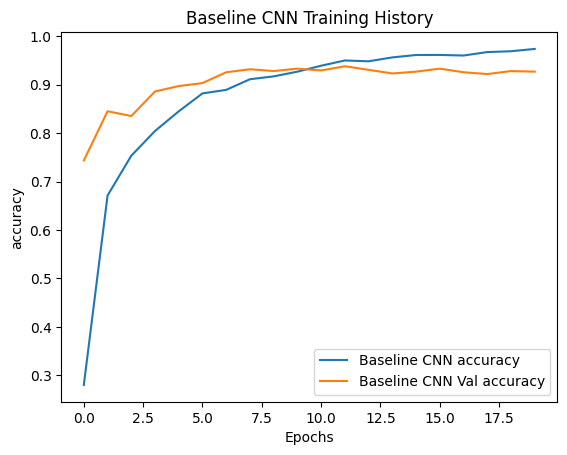

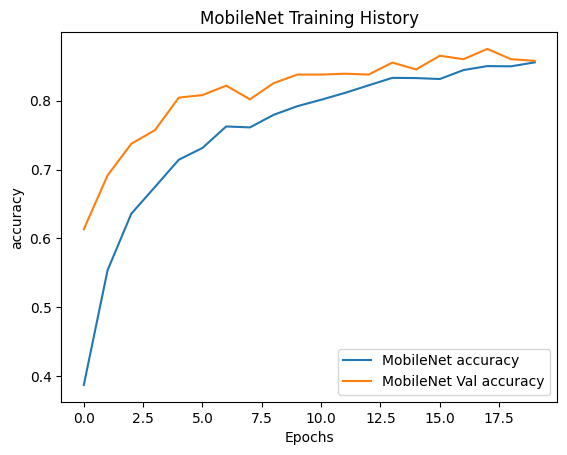

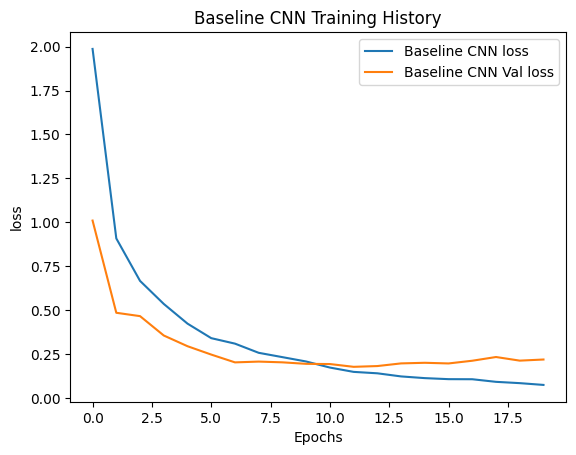

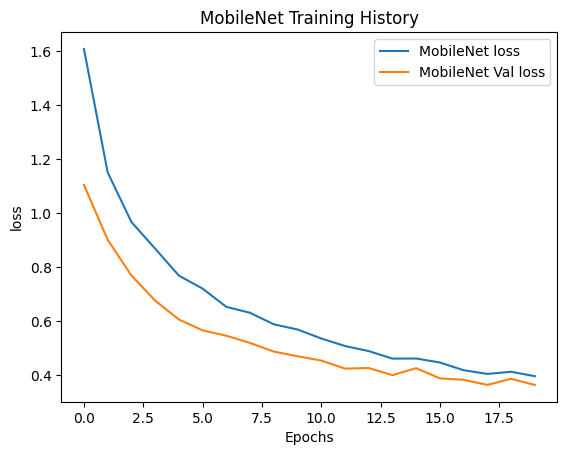

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,077,946 (42.26 MB)

 Trainable params: 3,692,648 (14.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,385,298 (28.17 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,625,562 (13.83 MB)

 Trainable params: 132,232 (516.53 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 264,466 (1.01 MB)

In [18]:
def create_baseline_cnn(input_shape=(128, 128, 3), num_classes=8, learning_rate=0.001):
    """Baseline CNN Model"""
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=8, learning_rate=0.001):
    """MobileNet-based Model"""
    base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    # Freeze base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Function to train and evaluate the model
def train_and_evaluate(model, train_gen, valid_gen, epochs):
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return history


# Create models
baseline_model = create_baseline_cnn(input_shape=(128, 128, 3), num_classes=8)
mobilenet_model = create_mobilenet_model(input_shape=(224, 224, 3), num_classes=8)


# Train and evaluate models
print("Training Baseline CNN Model:")
history_naive = train_and_evaluate(baseline_model, sequential_train_gen, sequential_valid_gen, epochs=EPOCHS)


print("Training MobileNet Model:")
history_mobilenet = train_and_evaluate(mobilenet_model, mobilenet_train_gen, mobilenet_valid_gen, epochs=EPOCHS)

# Plotting Training History for Comparison
def plot_history(history, model_name, plot_type):
    plt.plot(history.history[plot_type], label=f'{model_name} {plot_type}')
    plt.plot(history.history[f'val_{plot_type}'], label=f'{model_name} Val {plot_type}')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel(f'{plot_type}')
    plt.legend()
    plt.show()

# Plot accuracy for each model
plot_history(history_naive, 'Baseline CNN', plot_type='accuracy')
plot_history(history_mobilenet, 'MobileNet', plot_type='accuracy')

# Plot accuracy for each model
plot_history(history_naive, 'Baseline CNN', plot_type='loss')
plot_history(history_mobilenet, 'MobileNet', plot_type='loss')


baseline_model.summary()
mobilenet_model.summary()

baseline_model.save('baseline_model.keras')
mobilenet_model.save('mobilenet_model.keras')

## Model Testing

Found 6001 images belonging to 8 classes.
Evaluating Baseline CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 697ms/step - accuracy: 0.9865 - loss: 0.0525
Baseline CNN Test Loss: 0.06804871559143066
Baseline CNN Test Accuracy: 0.9818363785743713
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 702ms/step


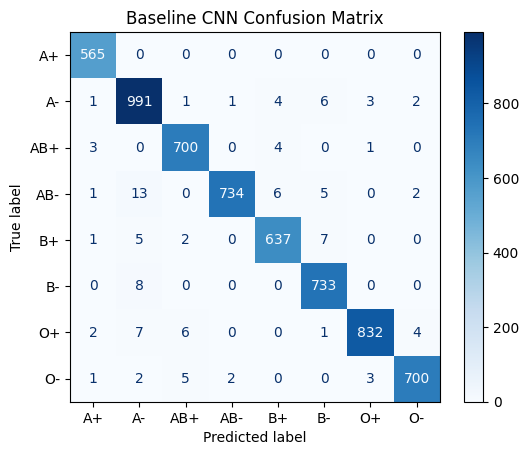

Baseline CNN Classification Report:
               precision    recall  f1-score   support

          A+       0.98      1.00      0.99       565
          A-       0.97      0.98      0.97      1009
         AB+       0.98      0.99      0.98       708
         AB-       1.00      0.96      0.98       761
          B+       0.98      0.98      0.98       652
          B-       0.97      0.99      0.98       741
          O+       0.99      0.98      0.98       852
          O-       0.99      0.98      0.99       713

    accuracy                           0.98      6001
   macro avg       0.98      0.98      0.98      6001
weighted avg       0.98      0.98      0.98      6001

Training histories not available for plotting.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import load_model

# Evaluate and plot results for a model
def evaluate_and_plot(model, test_generator, model_name):
    print(f"Evaluating {model_name}...")
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f"{model_name} Test Loss: {test_loss}")
    print(f"{model_name} Test Accuracy: {test_accuracy}")

    # Predict on test data
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Classification Report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"{model_name} Classification Report:\n", report)

# Load your test dataset
test_data_dir = "/content/drive/MyDrive/BLOOD_GROUP_DATASET"  # Update path
img_height, img_width = 128, 128  # Ensure dimensions match the model
batch_size = 128

# Create test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load models
baseline_model = load_model('baseline_model.keras')

# Evaluate and plot results for each model
evaluate_and_plot(baseline_model, test_generator, "Baseline CNN")

# Plot training histories if available
if 'history_naive' in locals():
    # Plot accuracy
    plot_history(history_naive, 'Baseline CNN', plot_type='accuracy')

    # Plot loss
    plot_history(history_naive, 'Baseline CNN', plot_type='loss')
else:
    print("Training histories not available for plotting.")

## Resnet 50

In [ ]:
'''def create_resnet_model(input_shape=(224, 224, 3), num_classes=8, learning_rate=1e-3):
    """ResNet50-based Model"""
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model
    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = create_resnet_model(input_shape=(224, 224, 3), num_classes=8)

print("Training ResNet Model:")
history_resnet = train_and_evaluate(resnet_model, resnet_train_gen, resnet_valid_gen, epochs=EPOCHS)

plot_history(history_resnet, 'ResNet50', plot_type='accuracy')

plot_history(history_resnet, 'ResNet50', plot_type='loss')

resnet_model.summary()

resnet_model.save('resnet_model.keras')'''